In [1]:
import tensorflow.keras
tensorflow.keras.__version__

'2.2.4-tf'

# Предсказание цен на дома: пример регрессии

IВ двух предыдущих примерах мы познакомились с задачами классификации, цель
которых состояла в предсказании одной дискретной метки для образца входных
данных. Другим распространенным типом задач машинного обучения является
регрессия, которая заключается в предсказании не дискретной метки, а значения
на непрерывной числовой прямой: например, предсказание температуры воздуха
на завтра по имеющимся метеорологическим данным или предсказание времени
завершения программного проекта по его спецификациям.

Не путайте регрессию с алгоритмом логистической регрессии. Как ни странно, логистическая регрессия не является регрессионным алгоритмом — это алгоритм классификации.


## Набор данных с ценами на жилье в Бостоне
Мы попытаемся предсказать медианную цену на дома в пригороде Бостона в середине 1970-х по таким данным о пригороде того времени, как уровень преступности, ставка местного имущественного налога и т. д. Набор данных, который
нам предстоит использовать, имеет интересное отличие от двух предыдущих
примеров. Он содержит относительно немного образцов данных: всего 506,
разбитых на 404 обучающих и 102 контрольных образца. И каждый признак во
входных данных (например, уровень преступности) имеет свой масштаб. Например,
некоторые признаки являются пропорциями и имеют значения между 0 и 1,
другие — между 1 и 12 и т. д.

Посмотрим на данные:

In [2]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

Как видите, у нас имеются 404 обучающих и 102 контрольных образца, каждый
с 13 числовыми признаками, такими как уровень преступности, среднее число
комнат в доме, удаленность от центральных дорог и т. д.

Цели — медианные значения цен на дома, занимаемые собственниками, в тысячах
долларов:

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13


Цены в основной массе находятся в диапазоне от 10 000 до 50 000 долларов США.

## Подготовка данных

Было бы проблематично передать в нейронную сеть значения, имеющие самые
разные диапазоны. Сеть, конечно, сможет автоматически адаптироваться к таким
разнородным данным, однако это усложнит обучение. На практике к таким данным принято применять нормализацию: для каждого признака во входных данных
(столбца в матрице входных данных) из каждого значения вычитается среднее по
этому признаку, и разность делится на стандартное отклонение, в результате признак центрируется по нулевому значению и имеет стандартное отклонение, равное
единице. Такую нормализацию легко выполнить с помощью Numpy.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

Обратите внимание на то, что величины, используемые для нормализации контрольных данных, вычисляются с использованием обучающих данных. Никогда не
следует использовать в работе какие-либо значения, вычисленные по контрольным
данным, даже для таких простых шагов, как нормализация данных.

## Конструирование сети

Из-за небольшого количества образцов мы будем использовать очень маленькую
сеть с двумя четырехмерными промежуточными слоями. Вообще говоря, чем
меньше обучающих данных, тем скорее наступит переобучение, а использование
маленькой сети — один из способов борьбы с ним.


In [7]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


Сеть заканчивается одномерным слоем, не имеющим функции активации (это
линейный слой). Это типичная конфигурация для скалярной регрессии (целью которой является предсказание одного значения на непрерывной числовой прямой).
Применение функции активации могло бы ограничить диапазон выходных значений: например, если в последнем слое применить функцию активации `sigmoid`, сеть
обучилась бы предсказывать только значения из диапазона между 0 и 1. В данном
случае, с линейным последним слоем, сеть способна предсказывать значения из
любого диапазона.
Обратите внимание на то, что сеть компилируется с функцией потерь `mse` — `mean
squared error` (среднеквадратичная ошибка), вычисляющей квадрат разности между
предсказанными и целевыми значениями. Эта функция широко используется
в задачах регрессии.
Мы также включили новый параметр в мониторинг на этапе обучения: `mae` — `mean
absolute error` (средняя абсолютная ошибка). Это абсолютное значение разности
между предсказанными и целевыми значениями. Например, значение `MAE`, равное 0,5,
в этой задаче означает, что в среднем прогнозы отклоняются на 500 долларов США.


## Оценка решения методом перекрестной проверки по K блокам


Чтобы оценить качество сети в ходе корректировки ее параметров (таких, как
количество эпох обучения), можно разбить исходные данные на обучающий
и проверочный наборы, как это делалось в предыдущих примерах. Однако так
как у нас и без того небольшой набор данных, проверочный набор получился бы
слишком маленьким (скажем, что-нибудь около 100 образцов). Как следствие,
оценки при проверке могут сильно меняться в зависимости от того, какие данные попадут в проверочный и обучающий наборы: оценки при проверке могут иметь слишком большой разброс. Это не позволит надежно оценить качество
модели.

Лучшей практикой в таких ситуациях является применение перекрестной проверки по K блокам (K-fold cross-validation). Суть ее заключается в разделении доступных данных на K блоков (обычно K = 4 или 5),
создании K идентичных моделей и обучении каждой на K-1 блоках с оценкой по
оставшимся блокам. По полученным K оценкам вычисляется среднее значение,
которое принимается как оценка модели. В коде такая проверка реализуется достаточно просто.

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Подготовка проверочных данных: данных из блока с номером k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Подготовка обучающих данных: данных из остальных блоков

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Конструирование модели Keras (уже скомпилированной)
    model = build_model()
   
    # Обучение модели (в режиме без
    # вывода сообщений, verbose = 0)

    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Оценка модели по проверочным данным
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=1)
    all_scores.append(val_mae)

W0221 09:39:58.877948 140100744312576 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1253: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0221 09:39:58.946494 140100744312576 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer_utils.py:123: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


processing fold # 0
101/101==============================] - 0s 259us/sample - loss: 10.2933 - mean_absolute_error: 2.2238
processing fold # 1
101/101==============================] - 0s 281us/sample - loss: 13.8477 - mean_absolute_error: 2.5046
processing fold # 2
101/101==============================] - 0s 307us/sample - loss: 15.3186 - mean_absolute_error: 2.5605
processing fold # 3
101/101==============================] - 0s 346us/sample - loss: 11.7181 - mean_absolute_error: 2.4176


Выполнив этот код с num_epochs = 100, мы получили следующие результаты:

In [9]:
all_scores

[2.2238429, 2.504599, 2.5604608, 2.417583]

In [10]:
np.mean(all_scores)

2.4266214


Разные прогоны действительно показывают разные оценки, от 2,6 до 3,2. Средняя
(3,0) выглядит более достоверно, чем любая из оценок отдельных прогонов, —
в этом главная ценность перекрестной проверки по K блокам. В данном случае
средняя ошибка составила 3000 долларов, что довольно много, если вспомнить,
что цены колеблются в диапазоне от 10 000 до 50 000 долларов.
Попробуем увеличить время обучения сети до 500 эпох. Чтобы получить информацию о качестве обучения модели в каждую эпоху, изменим цикл обучения и добавим сохранение оценки проверки перед началом эпохи.


In [11]:
from tensorflow.keras import backend as K

# Some memory clean-up
K.clear_session()

In [12]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
Train on 303 samples, validate on 101 samples
Epoch 1/500
303/303==============================] - 0s 2ms/sample - loss: 201.5190 - mean_absolute_error: 10.7195 - val_loss: 41.8617 - val_mean_absolute_error: 4.1157
Epoch 2/500
303/303==============================] - 0s 1ms/sample - loss: 30.7811 - mean_absolute_error: 3.7228 - val_loss: 25.4960 - val_mean_absolute_error: 3.3157
Epoch 3/500
303/303==============================] - 0s 1ms/sample - loss: 21.6308 - mean_absolute_error: 3.0529 - val_loss: 19.0045 - val_mean_absolute_error: 2.7031
Epoch 4/500
303/303==============================] - 0s 1ms/sample - loss: 17.1558 - mean_absolute_error: 2.7120 - val_loss: 15.8547 - val_mean_absolute_error: 2.7284
Epoch 5/500
303/303==============================] - 0s 1ms/sample - loss: 15.3915 - mean_absolute_error: 2.6410 - val_loss: 15.0778 - val_mean_absolute_error: 2.3363
Epoch 6/500
303/303==============================] - 0s 1ms/sample - loss: 14.6604 - mean_absolut

Epoch 50/500
303/303==============================] - 0s 1ms/sample - loss: 5.9676 - mean_absolute_error: 1.6137 - val_loss: 9.2080 - val_mean_absolute_error: 2.0669
Epoch 51/500
303/303==============================] - 0s 1ms/sample - loss: 6.3192 - mean_absolute_error: 1.6358 - val_loss: 9.5279 - val_mean_absolute_error: 2.1965
Epoch 52/500
303/303==============================] - 0s 1ms/sample - loss: 5.9634 - mean_absolute_error: 1.5896 - val_loss: 10.2967 - val_mean_absolute_error: 2.0109
Epoch 53/500
303/303==============================] - 0s 1ms/sample - loss: 6.1137 - mean_absolute_error: 1.5619 - val_loss: 8.9469 - val_mean_absolute_error: 2.0842
Epoch 54/500
303/303==============================] - 0s 1ms/sample - loss: 6.1592 - mean_absolute_error: 1.5546 - val_loss: 8.9436 - val_mean_absolute_error: 1.9861
Epoch 55/500
303/303==============================] - 0s 1ms/sample - loss: 6.2704 - mean_absolute_error: 1.5924 - val_loss: 8.9193 - val_mean_absolute_error: 2.1106
Epo

303/303==============================] - 0s 1ms/sample - loss: 2.9550 - mean_absolute_error: 1.2030 - val_loss: 9.9144 - val_mean_absolute_error: 2.2826
Epoch 149/500
303/303==============================] - 0s 1ms/sample - loss: 2.7788 - mean_absolute_error: 1.1826 - val_loss: 9.7713 - val_mean_absolute_error: 2.2368
Epoch 150/500
303/303==============================] - 0s 1ms/sample - loss: 2.7461 - mean_absolute_error: 1.1503 - val_loss: 10.8861 - val_mean_absolute_error: 2.4188
Epoch 151/500
303/303==============================] - 0s 1ms/sample - loss: 2.6140 - mean_absolute_error: 1.1158 - val_loss: 8.3350 - val_mean_absolute_error: 1.9999
Epoch 152/500
303/303==============================] - 0s 1ms/sample - loss: 2.8852 - mean_absolute_error: 1.1594 - val_loss: 9.1514 - val_mean_absolute_error: 2.1541
Epoch 153/500
303/303==============================] - 0s 1ms/sample - loss: 2.8045 - mean_absolute_error: 1.1951 - val_loss: 11.0513 - val_mean_absolute_error: 2.4141
Epoch 154/

303/303==============================] - 0s 1ms/sample - loss: 2.2213 - mean_absolute_error: 1.0866 - val_loss: 10.6888 - val_mean_absolute_error: 2.2953
Epoch 198/500
303/303==============================] - 0s 1ms/sample - loss: 2.0697 - mean_absolute_error: 1.0287 - val_loss: 9.1611 - val_mean_absolute_error: 2.1962
Epoch 199/500
303/303==============================] - 0s 1ms/sample - loss: 2.0603 - mean_absolute_error: 1.0625 - val_loss: 11.1592 - val_mean_absolute_error: 2.3371
Epoch 200/500
303/303==============================] - 0s 1ms/sample - loss: 2.3106 - mean_absolute_error: 1.0656 - val_loss: 8.9954 - val_mean_absolute_error: 2.0449
Epoch 201/500
303/303==============================] - 0s 1ms/sample - loss: 2.0642 - mean_absolute_error: 1.0172 - val_loss: 9.7819 - val_mean_absolute_error: 2.2271
Epoch 202/500
303/303==============================] - 0s 1ms/sample - loss: 1.9940 - mean_absolute_error: 1.0189 - val_loss: 9.6207 - val_mean_absolute_error: 2.1101
Epoch 203/

Epoch 246/500
303/303==============================] - 0s 1ms/sample - loss: 1.7772 - mean_absolute_error: 0.9528 - val_loss: 12.2262 - val_mean_absolute_error: 2.5556
Epoch 247/500
303/303==============================] - 0s 1ms/sample - loss: 1.8415 - mean_absolute_error: 0.9440 - val_loss: 12.5788 - val_mean_absolute_error: 2.5170
Epoch 248/500
303/303==============================] - 0s 1ms/sample - loss: 2.0143 - mean_absolute_error: 0.9923 - val_loss: 11.1632 - val_mean_absolute_error: 2.3661
Epoch 249/500
303/303==============================] - 0s 1ms/sample - loss: 2.0209 - mean_absolute_error: 0.9998 - val_loss: 11.1351 - val_mean_absolute_error: 2.4199
Epoch 250/500
303/303==============================] - 0s 1ms/sample - loss: 1.6798 - mean_absolute_error: 0.9415 - val_loss: 11.3437 - val_mean_absolute_error: 2.3149
Epoch 251/500
303/303==============================] - 0s 1ms/sample - loss: 1.8136 - mean_absolute_error: 0.9744 - val_loss: 11.9369 - val_mean_absolute_error:

Epoch 295/500
303/303==============================] - 0s 1ms/sample - loss: 1.7076 - mean_absolute_error: 0.9051 - val_loss: 11.1305 - val_mean_absolute_error: 2.4124
Epoch 296/500
303/303==============================] - 0s 1ms/sample - loss: 1.5022 - mean_absolute_error: 0.8660 - val_loss: 11.9352 - val_mean_absolute_error: 2.3098
Epoch 297/500
303/303==============================] - 0s 1ms/sample - loss: 1.4626 - mean_absolute_error: 0.8428 - val_loss: 10.9437 - val_mean_absolute_error: 2.2422
Epoch 298/500
303/303==============================] - 0s 1ms/sample - loss: 1.3690 - mean_absolute_error: 0.8232 - val_loss: 12.6907 - val_mean_absolute_error: 2.5412
Epoch 299/500
303/303==============================] - 0s 1ms/sample - loss: 1.4272 - mean_absolute_error: 0.8558 - val_loss: 12.4557 - val_mean_absolute_error: 2.3052
Epoch 300/500
303/303==============================] - 0s 1ms/sample - loss: 1.4646 - mean_absolute_error: 0.8766 - val_loss: 10.9342 - val_mean_absolute_error:

Epoch 344/500
303/303==============================] - 0s 1ms/sample - loss: 1.3351 - mean_absolute_error: 0.8449 - val_loss: 12.3021 - val_mean_absolute_error: 2.4341
Epoch 345/500
303/303==============================] - 0s 1ms/sample - loss: 1.3613 - mean_absolute_error: 0.8365 - val_loss: 10.0470 - val_mean_absolute_error: 2.2337
Epoch 346/500
303/303==============================] - 0s 1ms/sample - loss: 1.3722 - mean_absolute_error: 0.8100 - val_loss: 10.4942 - val_mean_absolute_error: 2.1435
Epoch 347/500
303/303==============================] - 0s 1ms/sample - loss: 1.4462 - mean_absolute_error: 0.8466 - val_loss: 10.4477 - val_mean_absolute_error: 2.2766
Epoch 348/500
303/303==============================] - 0s 1ms/sample - loss: 1.1918 - mean_absolute_error: 0.8157 - val_loss: 11.3115 - val_mean_absolute_error: 2.4214
Epoch 349/500
303/303==============================] - 0s 1ms/sample - loss: 1.2569 - mean_absolute_error: 0.8350 - val_loss: 10.6102 - val_mean_absolute_error:

Epoch 393/500
303/303==============================] - 0s 1ms/sample - loss: 1.1558 - mean_absolute_error: 0.7685 - val_loss: 12.2649 - val_mean_absolute_error: 2.4123
Epoch 394/500
303/303==============================] - 0s 1ms/sample - loss: 1.0074 - mean_absolute_error: 0.7323 - val_loss: 10.9522 - val_mean_absolute_error: 2.3198
Epoch 395/500
303/303==============================] - 0s 1ms/sample - loss: 1.1131 - mean_absolute_error: 0.7758 - val_loss: 10.1448 - val_mean_absolute_error: 2.2827
Epoch 396/500
303/303==============================] - 0s 1ms/sample - loss: 1.2450 - mean_absolute_error: 0.7688 - val_loss: 11.5181 - val_mean_absolute_error: 2.3915
Epoch 397/500
303/303==============================] - 0s 1ms/sample - loss: 1.1450 - mean_absolute_error: 0.7653 - val_loss: 10.4283 - val_mean_absolute_error: 2.2476
Epoch 398/500
303/303==============================] - 0s 1ms/sample - loss: 1.0659 - mean_absolute_error: 0.7328 - val_loss: 11.2398 - val_mean_absolute_error:

Epoch 442/500
303/303==============================] - 0s 1ms/sample - loss: 0.9628 - mean_absolute_error: 0.7116 - val_loss: 10.6565 - val_mean_absolute_error: 2.2162
Epoch 443/500
303/303==============================] - 0s 1ms/sample - loss: 0.9377 - mean_absolute_error: 0.6631 - val_loss: 11.4201 - val_mean_absolute_error: 2.2041
Epoch 444/500
303/303==============================] - 0s 1ms/sample - loss: 0.9995 - mean_absolute_error: 0.7284 - val_loss: 10.3836 - val_mean_absolute_error: 2.1616
Epoch 445/500
303/303==============================] - 0s 1ms/sample - loss: 1.0142 - mean_absolute_error: 0.7070 - val_loss: 10.4666 - val_mean_absolute_error: 2.2499
Epoch 446/500
303/303==============================] - 0s 1ms/sample - loss: 0.8788 - mean_absolute_error: 0.6860 - val_loss: 12.2246 - val_mean_absolute_error: 2.4951
Epoch 447/500
303/303==============================] - 0s 1ms/sample - loss: 1.0089 - mean_absolute_error: 0.7213 - val_loss: 11.0086 - val_mean_absolute_error:

Epoch 491/500
303/303==============================] - 0s 1ms/sample - loss: 0.9041 - mean_absolute_error: 0.6514 - val_loss: 11.2142 - val_mean_absolute_error: 2.3454
Epoch 492/500
303/303==============================] - 0s 1ms/sample - loss: 1.0323 - mean_absolute_error: 0.7120 - val_loss: 11.3262 - val_mean_absolute_error: 2.3444
Epoch 493/500
303/303==============================] - 0s 1ms/sample - loss: 0.8240 - mean_absolute_error: 0.6658 - val_loss: 12.1033 - val_mean_absolute_error: 2.3799
Epoch 494/500
303/303==============================] - 0s 1ms/sample - loss: 0.9818 - mean_absolute_error: 0.7263 - val_loss: 12.6158 - val_mean_absolute_error: 2.5740
Epoch 495/500
303/303==============================] - 0s 1ms/sample - loss: 0.8613 - mean_absolute_error: 0.6853 - val_loss: 11.6921 - val_mean_absolute_error: 2.4422
Epoch 496/500
303/303==============================] - 0s 1ms/sample - loss: 0.7856 - mean_absolute_error: 0.6610 - val_loss: 12.7580 - val_mean_absolute_error:

303/303==============================] - 0s 1ms/sample - loss: 3.8204 - mean_absolute_error: 1.2852 - val_loss: 16.7321 - val_mean_absolute_error: 2.6508
Epoch 89/500
303/303==============================] - 0s 1ms/sample - loss: 3.5891 - mean_absolute_error: 1.3566 - val_loss: 16.2784 - val_mean_absolute_error: 2.6037
Epoch 90/500
303/303==============================] - 0s 1ms/sample - loss: 3.6657 - mean_absolute_error: 1.3066 - val_loss: 20.0866 - val_mean_absolute_error: 2.7134
Epoch 91/500
303/303==============================] - 0s 1ms/sample - loss: 3.6594 - mean_absolute_error: 1.3388 - val_loss: 19.6533 - val_mean_absolute_error: 2.7332
Epoch 92/500
303/303==============================] - 0s 1ms/sample - loss: 3.3296 - mean_absolute_error: 1.3068 - val_loss: 17.1293 - val_mean_absolute_error: 2.7609
Epoch 93/500
303/303==============================] - 0s 1ms/sample - loss: 2.8435 - mean_absolute_error: 1.2419 - val_loss: 15.4748 - val_mean_absolute_error: 2.5327
Epoch 94/50

Epoch 137/500
303/303==============================] - 0s 1ms/sample - loss: 2.6533 - mean_absolute_error: 1.1442 - val_loss: 21.9687 - val_mean_absolute_error: 2.8465
Epoch 138/500
303/303==============================] - 0s 1ms/sample - loss: 2.2148 - mean_absolute_error: 1.0857 - val_loss: 26.1788 - val_mean_absolute_error: 3.1124
Epoch 139/500
303/303==============================] - 0s 1ms/sample - loss: 2.3981 - mean_absolute_error: 1.1348 - val_loss: 19.3462 - val_mean_absolute_error: 2.8606
Epoch 140/500
303/303==============================] - 0s 1ms/sample - loss: 2.3312 - mean_absolute_error: 1.1188 - val_loss: 21.6133 - val_mean_absolute_error: 2.9776
Epoch 141/500
303/303==============================] - 0s 1ms/sample - loss: 2.4896 - mean_absolute_error: 1.1397 - val_loss: 27.3946 - val_mean_absolute_error: 3.1852
Epoch 142/500
303/303==============================] - 0s 1ms/sample - loss: 2.3667 - mean_absolute_error: 1.1095 - val_loss: 13.6935 - val_mean_absolute_error:

Epoch 186/500
303/303==============================] - 0s 1ms/sample - loss: 1.7356 - mean_absolute_error: 1.0071 - val_loss: 25.1192 - val_mean_absolute_error: 3.0883
Epoch 187/500
303/303==============================] - 0s 1ms/sample - loss: 1.6563 - mean_absolute_error: 0.9497 - val_loss: 15.4701 - val_mean_absolute_error: 2.7407
Epoch 188/500
303/303==============================] - 0s 1ms/sample - loss: 1.8448 - mean_absolute_error: 0.9808 - val_loss: 20.0917 - val_mean_absolute_error: 2.8245
Epoch 189/500
303/303==============================] - 0s 1ms/sample - loss: 1.8207 - mean_absolute_error: 0.9867 - val_loss: 21.3418 - val_mean_absolute_error: 2.9517
Epoch 190/500
303/303==============================] - 0s 1ms/sample - loss: 1.7670 - mean_absolute_error: 0.9720 - val_loss: 21.1687 - val_mean_absolute_error: 2.9046
Epoch 191/500
303/303==============================] - 0s 1ms/sample - loss: 1.9505 - mean_absolute_error: 1.0080 - val_loss: 18.3443 - val_mean_absolute_error:

Epoch 235/500
303/303==============================] - 0s 1ms/sample - loss: 1.3876 - mean_absolute_error: 0.8950 - val_loss: 18.9754 - val_mean_absolute_error: 2.8628
Epoch 236/500
303/303==============================] - 0s 1ms/sample - loss: 1.4352 - mean_absolute_error: 0.8865 - val_loss: 17.5316 - val_mean_absolute_error: 2.7444
Epoch 237/500
303/303==============================] - 0s 1ms/sample - loss: 1.5028 - mean_absolute_error: 0.8790 - val_loss: 19.6199 - val_mean_absolute_error: 2.9309
Epoch 238/500
303/303==============================] - 0s 1ms/sample - loss: 1.3782 - mean_absolute_error: 0.8641 - val_loss: 19.7056 - val_mean_absolute_error: 2.9568
Epoch 239/500
303/303==============================] - 0s 1ms/sample - loss: 1.3406 - mean_absolute_error: 0.8732 - val_loss: 24.0101 - val_mean_absolute_error: 2.9678
Epoch 240/500
303/303==============================] - 0s 1ms/sample - loss: 1.3114 - mean_absolute_error: 0.8507 - val_loss: 19.2137 - val_mean_absolute_error:

Epoch 284/500
303/303==============================] - 0s 1ms/sample - loss: 1.1332 - mean_absolute_error: 0.7818 - val_loss: 19.4685 - val_mean_absolute_error: 2.9252
Epoch 285/500
303/303==============================] - 0s 1ms/sample - loss: 1.3278 - mean_absolute_error: 0.8150 - val_loss: 23.5166 - val_mean_absolute_error: 3.3477
Epoch 286/500
303/303==============================] - 0s 1ms/sample - loss: 1.2457 - mean_absolute_error: 0.8039 - val_loss: 18.8190 - val_mean_absolute_error: 2.9869
Epoch 287/500
303/303==============================] - 0s 1ms/sample - loss: 1.3266 - mean_absolute_error: 0.8069 - val_loss: 16.1944 - val_mean_absolute_error: 2.7861
Epoch 288/500
303/303==============================] - 0s 1ms/sample - loss: 1.0980 - mean_absolute_error: 0.7489 - val_loss: 14.8577 - val_mean_absolute_error: 2.8063
Epoch 289/500
303/303==============================] - 0s 1ms/sample - loss: 1.2301 - mean_absolute_error: 0.7928 - val_loss: 16.1164 - val_mean_absolute_error:

Epoch 333/500
303/303==============================] - 0s 1ms/sample - loss: 1.0773 - mean_absolute_error: 0.7535 - val_loss: 22.2280 - val_mean_absolute_error: 3.1007
Epoch 334/500
303/303==============================] - 0s 1ms/sample - loss: 1.1675 - mean_absolute_error: 0.7816 - val_loss: 18.7469 - val_mean_absolute_error: 2.9790
Epoch 335/500
303/303==============================] - 0s 1ms/sample - loss: 1.1380 - mean_absolute_error: 0.7674 - val_loss: 17.2595 - val_mean_absolute_error: 2.8981
Epoch 336/500
303/303==============================] - 0s 1ms/sample - loss: 1.0459 - mean_absolute_error: 0.7706 - val_loss: 20.0156 - val_mean_absolute_error: 2.9439
Epoch 337/500
303/303==============================] - 0s 1ms/sample - loss: 1.0808 - mean_absolute_error: 0.7257 - val_loss: 23.7910 - val_mean_absolute_error: 3.2375
Epoch 338/500
303/303==============================] - 0s 1ms/sample - loss: 1.0414 - mean_absolute_error: 0.7470 - val_loss: 17.7959 - val_mean_absolute_error:

Epoch 382/500
303/303==============================] - 0s 1ms/sample - loss: 1.0395 - mean_absolute_error: 0.7411 - val_loss: 19.7331 - val_mean_absolute_error: 2.9992
Epoch 383/500
303/303==============================] - 0s 1ms/sample - loss: 0.9754 - mean_absolute_error: 0.7147 - val_loss: 18.5260 - val_mean_absolute_error: 3.0300
Epoch 384/500
303/303==============================] - 0s 1ms/sample - loss: 0.9824 - mean_absolute_error: 0.6887 - val_loss: 19.4772 - val_mean_absolute_error: 3.0441
Epoch 385/500
303/303==============================] - 0s 1ms/sample - loss: 1.0775 - mean_absolute_error: 0.7600 - val_loss: 16.2604 - val_mean_absolute_error: 2.9237
Epoch 386/500
303/303==============================] - 0s 1ms/sample - loss: 0.8720 - mean_absolute_error: 0.6984 - val_loss: 16.2472 - val_mean_absolute_error: 2.9122
Epoch 387/500
303/303==============================] - 0s 1ms/sample - loss: 0.9030 - mean_absolute_error: 0.7023 - val_loss: 26.1246 - val_mean_absolute_error:

Epoch 431/500
303/303==============================] - 0s 1ms/sample - loss: 0.9646 - mean_absolute_error: 0.6865 - val_loss: 23.0177 - val_mean_absolute_error: 3.1374
Epoch 432/500
303/303==============================] - 0s 1ms/sample - loss: 0.8480 - mean_absolute_error: 0.6953 - val_loss: 20.6324 - val_mean_absolute_error: 3.0829
Epoch 433/500
303/303==============================] - 0s 1ms/sample - loss: 0.8333 - mean_absolute_error: 0.6783 - val_loss: 21.7057 - val_mean_absolute_error: 3.1463
Epoch 434/500
303/303==============================] - 0s 1ms/sample - loss: 1.0099 - mean_absolute_error: 0.6853 - val_loss: 17.3387 - val_mean_absolute_error: 3.0191
Epoch 435/500
303/303==============================] - 0s 1ms/sample - loss: 0.8536 - mean_absolute_error: 0.7117 - val_loss: 22.2828 - val_mean_absolute_error: 3.0597
Epoch 436/500
303/303==============================] - 0s 1ms/sample - loss: 0.8422 - mean_absolute_error: 0.6399 - val_loss: 18.7686 - val_mean_absolute_error:

Epoch 480/500
303/303==============================] - 0s 1ms/sample - loss: 0.7825 - mean_absolute_error: 0.6510 - val_loss: 15.3824 - val_mean_absolute_error: 2.7987
Epoch 481/500
303/303==============================] - 0s 1ms/sample - loss: 0.7857 - mean_absolute_error: 0.6295 - val_loss: 18.6080 - val_mean_absolute_error: 2.9611
Epoch 482/500
303/303==============================] - 0s 1ms/sample - loss: 0.8434 - mean_absolute_error: 0.7067 - val_loss: 19.6574 - val_mean_absolute_error: 3.0897
Epoch 483/500
303/303==============================] - 0s 1ms/sample - loss: 0.7965 - mean_absolute_error: 0.6437 - val_loss: 19.5514 - val_mean_absolute_error: 3.0913
Epoch 484/500
303/303==============================] - 0s 1ms/sample - loss: 0.8378 - mean_absolute_error: 0.6708 - val_loss: 18.3043 - val_mean_absolute_error: 2.9639
Epoch 485/500
303/303==============================] - 0s 1ms/sample - loss: 0.7584 - mean_absolute_error: 0.6621 - val_loss: 20.3522 - val_mean_absolute_error:

303/303==============================] - 0s 1ms/sample - loss: 3.7244 - mean_absolute_error: 1.3148 - val_loss: 13.5832 - val_mean_absolute_error: 2.4734
Epoch 78/500
303/303==============================] - 0s 1ms/sample - loss: 3.4743 - mean_absolute_error: 1.3144 - val_loss: 15.6609 - val_mean_absolute_error: 2.8434
Epoch 79/500
303/303==============================] - 0s 1ms/sample - loss: 3.4298 - mean_absolute_error: 1.2989 - val_loss: 12.6866 - val_mean_absolute_error: 2.3636
Epoch 80/500
303/303==============================] - 0s 1ms/sample - loss: 3.2948 - mean_absolute_error: 1.3296 - val_loss: 13.0841 - val_mean_absolute_error: 2.4319
Epoch 81/500
303/303==============================] - 0s 1ms/sample - loss: 3.5328 - mean_absolute_error: 1.3155 - val_loss: 13.9063 - val_mean_absolute_error: 2.4928
Epoch 82/500
303/303==============================] - 0s 1ms/sample - loss: 3.3515 - mean_absolute_error: 1.2907 - val_loss: 13.7533 - val_mean_absolute_error: 2.5179
Epoch 83/50

Epoch 126/500
303/303==============================] - 0s 1ms/sample - loss: 2.0892 - mean_absolute_error: 1.0569 - val_loss: 13.9116 - val_mean_absolute_error: 2.5713
Epoch 127/500
303/303==============================] - 0s 1ms/sample - loss: 2.4078 - mean_absolute_error: 1.0954 - val_loss: 16.5912 - val_mean_absolute_error: 2.9890
Epoch 128/500
303/303==============================] - 0s 1ms/sample - loss: 2.4894 - mean_absolute_error: 1.1306 - val_loss: 13.3653 - val_mean_absolute_error: 2.5210
Epoch 129/500
303/303==============================] - 0s 1ms/sample - loss: 2.2608 - mean_absolute_error: 1.0862 - val_loss: 14.0064 - val_mean_absolute_error: 2.5522
Epoch 130/500
303/303==============================] - 0s 1ms/sample - loss: 2.1908 - mean_absolute_error: 1.0209 - val_loss: 13.5597 - val_mean_absolute_error: 2.5689
Epoch 131/500
303/303==============================] - 0s 1ms/sample - loss: 2.2593 - mean_absolute_error: 1.0467 - val_loss: 12.8960 - val_mean_absolute_error:

Epoch 175/500
303/303==============================] - 0s 1ms/sample - loss: 1.6236 - mean_absolute_error: 0.9334 - val_loss: 14.0827 - val_mean_absolute_error: 2.6402
Epoch 176/500
303/303==============================] - 0s 1ms/sample - loss: 1.5670 - mean_absolute_error: 0.9129 - val_loss: 14.6904 - val_mean_absolute_error: 2.6727
Epoch 177/500
303/303==============================] - 0s 1ms/sample - loss: 1.5936 - mean_absolute_error: 0.9305 - val_loss: 14.0538 - val_mean_absolute_error: 2.6795
Epoch 178/500
303/303==============================] - 0s 1ms/sample - loss: 1.7003 - mean_absolute_error: 0.9832 - val_loss: 14.0766 - val_mean_absolute_error: 2.6444
Epoch 179/500
303/303==============================] - 0s 1ms/sample - loss: 1.5544 - mean_absolute_error: 0.9125 - val_loss: 13.6070 - val_mean_absolute_error: 2.6067
Epoch 180/500
303/303==============================] - 0s 1ms/sample - loss: 1.5901 - mean_absolute_error: 0.9047 - val_loss: 15.0248 - val_mean_absolute_error:

Epoch 224/500
303/303==============================] - 0s 1ms/sample - loss: 1.2344 - mean_absolute_error: 0.7808 - val_loss: 14.1850 - val_mean_absolute_error: 2.6969
Epoch 225/500
303/303==============================] - 0s 1ms/sample - loss: 1.2116 - mean_absolute_error: 0.8242 - val_loss: 14.7413 - val_mean_absolute_error: 2.7601
Epoch 226/500
303/303==============================] - 0s 1ms/sample - loss: 1.2672 - mean_absolute_error: 0.8083 - val_loss: 15.0671 - val_mean_absolute_error: 2.7692
Epoch 227/500
303/303==============================] - 0s 1ms/sample - loss: 1.3200 - mean_absolute_error: 0.8484 - val_loss: 15.1360 - val_mean_absolute_error: 2.7845
Epoch 228/500
303/303==============================] - 0s 1ms/sample - loss: 1.2736 - mean_absolute_error: 0.8401 - val_loss: 14.6447 - val_mean_absolute_error: 2.6964
Epoch 229/500
303/303==============================] - 0s 1ms/sample - loss: 1.1807 - mean_absolute_error: 0.8145 - val_loss: 14.7526 - val_mean_absolute_error:

Epoch 273/500
303/303==============================] - 0s 1ms/sample - loss: 1.0164 - mean_absolute_error: 0.7580 - val_loss: 15.8402 - val_mean_absolute_error: 3.0171
Epoch 274/500
303/303==============================] - 0s 1ms/sample - loss: 1.0057 - mean_absolute_error: 0.7360 - val_loss: 14.2462 - val_mean_absolute_error: 2.6344
Epoch 275/500
303/303==============================] - 0s 1ms/sample - loss: 1.1289 - mean_absolute_error: 0.7919 - val_loss: 15.9821 - val_mean_absolute_error: 2.8028
Epoch 276/500
303/303==============================] - 0s 1ms/sample - loss: 0.8458 - mean_absolute_error: 0.7030 - val_loss: 15.6007 - val_mean_absolute_error: 2.9219
Epoch 277/500
303/303==============================] - 0s 1ms/sample - loss: 1.0835 - mean_absolute_error: 0.7408 - val_loss: 14.8246 - val_mean_absolute_error: 2.7946
Epoch 278/500
303/303==============================] - 0s 1ms/sample - loss: 0.9500 - mean_absolute_error: 0.7551 - val_loss: 14.2667 - val_mean_absolute_error:

Epoch 322/500
303/303==============================] - 0s 1ms/sample - loss: 0.9124 - mean_absolute_error: 0.6976 - val_loss: 16.4035 - val_mean_absolute_error: 2.9048
Epoch 323/500
303/303==============================] - 0s 1ms/sample - loss: 1.0077 - mean_absolute_error: 0.7058 - val_loss: 16.0138 - val_mean_absolute_error: 2.8981
Epoch 324/500
303/303==============================] - 0s 1ms/sample - loss: 0.8657 - mean_absolute_error: 0.6844 - val_loss: 16.5177 - val_mean_absolute_error: 2.9275
Epoch 325/500
303/303==============================] - 0s 1ms/sample - loss: 0.8201 - mean_absolute_error: 0.6769 - val_loss: 17.5679 - val_mean_absolute_error: 3.0803
Epoch 326/500
303/303==============================] - 0s 1ms/sample - loss: 0.8270 - mean_absolute_error: 0.6937 - val_loss: 16.2777 - val_mean_absolute_error: 2.8836
Epoch 327/500
303/303==============================] - 0s 1ms/sample - loss: 0.8290 - mean_absolute_error: 0.6837 - val_loss: 16.8511 - val_mean_absolute_error:

Epoch 371/500
303/303==============================] - 0s 1ms/sample - loss: 0.7763 - mean_absolute_error: 0.6449 - val_loss: 16.2933 - val_mean_absolute_error: 2.8752
Epoch 372/500
303/303==============================] - 0s 1ms/sample - loss: 0.9264 - mean_absolute_error: 0.6758 - val_loss: 15.6644 - val_mean_absolute_error: 2.8925
Epoch 373/500
303/303==============================] - 0s 1ms/sample - loss: 0.8013 - mean_absolute_error: 0.6728 - val_loss: 14.7800 - val_mean_absolute_error: 2.6838
Epoch 374/500
303/303==============================] - 0s 1ms/sample - loss: 0.7960 - mean_absolute_error: 0.6763 - val_loss: 14.6944 - val_mean_absolute_error: 2.7521
Epoch 375/500
303/303==============================] - 0s 1ms/sample - loss: 0.8455 - mean_absolute_error: 0.6805 - val_loss: 15.2629 - val_mean_absolute_error: 2.8227
Epoch 376/500
303/303==============================] - 0s 1ms/sample - loss: 0.7990 - mean_absolute_error: 0.6636 - val_loss: 15.8269 - val_mean_absolute_error:

Epoch 420/500
303/303==============================] - 0s 1ms/sample - loss: 0.6482 - mean_absolute_error: 0.6071 - val_loss: 14.3326 - val_mean_absolute_error: 2.7346
Epoch 421/500
303/303==============================] - 0s 1ms/sample - loss: 0.7276 - mean_absolute_error: 0.6324 - val_loss: 14.6471 - val_mean_absolute_error: 2.7987
Epoch 422/500
303/303==============================] - 0s 1ms/sample - loss: 0.7730 - mean_absolute_error: 0.6354 - val_loss: 15.2100 - val_mean_absolute_error: 2.7884
Epoch 423/500
303/303==============================] - 0s 1ms/sample - loss: 0.6394 - mean_absolute_error: 0.6156 - val_loss: 15.1177 - val_mean_absolute_error: 2.7291
Epoch 424/500
303/303==============================] - 0s 1ms/sample - loss: 0.6749 - mean_absolute_error: 0.6085 - val_loss: 14.4155 - val_mean_absolute_error: 2.7914
Epoch 425/500
303/303==============================] - 0s 1ms/sample - loss: 0.7545 - mean_absolute_error: 0.6306 - val_loss: 14.2991 - val_mean_absolute_error:

Epoch 469/500
303/303==============================] - 0s 1ms/sample - loss: 0.6452 - mean_absolute_error: 0.5871 - val_loss: 14.1834 - val_mean_absolute_error: 2.6977
Epoch 470/500
303/303==============================] - 0s 1ms/sample - loss: 0.6760 - mean_absolute_error: 0.6131 - val_loss: 14.1589 - val_mean_absolute_error: 2.7669
Epoch 471/500
303/303==============================] - 0s 1ms/sample - loss: 0.6534 - mean_absolute_error: 0.6059 - val_loss: 13.4552 - val_mean_absolute_error: 2.7057
Epoch 472/500
303/303==============================] - 0s 1ms/sample - loss: 0.7102 - mean_absolute_error: 0.6124 - val_loss: 14.1760 - val_mean_absolute_error: 2.7521
Epoch 473/500
303/303==============================] - 0s 1ms/sample - loss: 0.6001 - mean_absolute_error: 0.5795 - val_loss: 14.7944 - val_mean_absolute_error: 2.8084
Epoch 474/500
303/303==============================] - 0s 1ms/sample - loss: 0.6370 - mean_absolute_error: 0.6142 - val_loss: 15.0249 - val_mean_absolute_error:

303/303==============================] - 0s 1ms/sample - loss: 5.7525 - mean_absolute_error: 1.5588 - val_loss: 11.0937 - val_mean_absolute_error: 2.3837
Epoch 67/500
303/303==============================] - 0s 1ms/sample - loss: 5.2664 - mean_absolute_error: 1.5430 - val_loss: 11.3040 - val_mean_absolute_error: 2.4178
Epoch 68/500
303/303==============================] - 0s 1ms/sample - loss: 5.2884 - mean_absolute_error: 1.4998 - val_loss: 12.7022 - val_mean_absolute_error: 2.6083
Epoch 69/500
303/303==============================] - 0s 1ms/sample - loss: 5.6824 - mean_absolute_error: 1.5265 - val_loss: 11.7739 - val_mean_absolute_error: 2.4881
Epoch 70/500
303/303==============================] - 0s 1ms/sample - loss: 5.2754 - mean_absolute_error: 1.5008 - val_loss: 10.7091 - val_mean_absolute_error: 2.3716
Epoch 71/500
303/303==============================] - 0s 1ms/sample - loss: 5.2356 - mean_absolute_error: 1.5628 - val_loss: 13.2458 - val_mean_absolute_error: 2.6755
Epoch 72/50

303/303==============================] - 0s 1ms/sample - loss: 3.8234 - mean_absolute_error: 1.2697 - val_loss: 15.1513 - val_mean_absolute_error: 2.9094
Epoch 116/500
303/303==============================] - 0s 1ms/sample - loss: 4.0984 - mean_absolute_error: 1.3378 - val_loss: 11.8871 - val_mean_absolute_error: 2.5198
Epoch 117/500
303/303==============================] - 0s 1ms/sample - loss: 3.7677 - mean_absolute_error: 1.2942 - val_loss: 11.7463 - val_mean_absolute_error: 2.4736
Epoch 118/500
303/303==============================] - 0s 1ms/sample - loss: 3.8331 - mean_absolute_error: 1.2953 - val_loss: 13.1369 - val_mean_absolute_error: 2.6764
Epoch 119/500
303/303==============================] - 0s 1ms/sample - loss: 3.9259 - mean_absolute_error: 1.3282 - val_loss: 13.8315 - val_mean_absolute_error: 2.7927
Epoch 120/500
303/303==============================] - 0s 1ms/sample - loss: 3.7219 - mean_absolute_error: 1.2469 - val_loss: 13.4008 - val_mean_absolute_error: 2.6885
Epoch 

Epoch 164/500
303/303==============================] - 0s 1ms/sample - loss: 2.9492 - mean_absolute_error: 1.1759 - val_loss: 12.8385 - val_mean_absolute_error: 2.5811
Epoch 165/500
303/303==============================] - 0s 1ms/sample - loss: 3.4339 - mean_absolute_error: 1.2069 - val_loss: 13.0040 - val_mean_absolute_error: 2.7187
Epoch 166/500
303/303==============================] - 0s 1ms/sample - loss: 3.1163 - mean_absolute_error: 1.1392 - val_loss: 13.1929 - val_mean_absolute_error: 2.6665
Epoch 167/500
303/303==============================] - 0s 1ms/sample - loss: 3.0946 - mean_absolute_error: 1.1441 - val_loss: 12.8031 - val_mean_absolute_error: 2.5463
Epoch 168/500
303/303==============================] - 0s 1ms/sample - loss: 3.1981 - mean_absolute_error: 1.1784 - val_loss: 12.0360 - val_mean_absolute_error: 2.4879
Epoch 169/500
303/303==============================] - 0s 1ms/sample - loss: 3.3024 - mean_absolute_error: 1.1338 - val_loss: 13.4965 - val_mean_absolute_error:

Epoch 213/500
303/303==============================] - 0s 1ms/sample - loss: 2.3039 - mean_absolute_error: 1.0119 - val_loss: 13.2748 - val_mean_absolute_error: 2.5532
Epoch 214/500
303/303==============================] - 0s 1ms/sample - loss: 2.5176 - mean_absolute_error: 1.1435 - val_loss: 13.7586 - val_mean_absolute_error: 2.5793
Epoch 215/500
303/303==============================] - 0s 1ms/sample - loss: 2.4165 - mean_absolute_error: 1.0349 - val_loss: 12.6034 - val_mean_absolute_error: 2.4960
Epoch 216/500
303/303==============================] - 0s 1ms/sample - loss: 2.3682 - mean_absolute_error: 1.0647 - val_loss: 13.8973 - val_mean_absolute_error: 2.6736
Epoch 217/500
303/303==============================] - 0s 1ms/sample - loss: 2.2626 - mean_absolute_error: 1.0258 - val_loss: 13.6964 - val_mean_absolute_error: 2.5626
Epoch 218/500
303/303==============================] - 0s 1ms/sample - loss: 2.8040 - mean_absolute_error: 1.0365 - val_loss: 14.0530 - val_mean_absolute_error:

Epoch 262/500
303/303==============================] - 0s 1ms/sample - loss: 2.0308 - mean_absolute_error: 1.0054 - val_loss: 12.8497 - val_mean_absolute_error: 2.5619
Epoch 263/500
303/303==============================] - 0s 1ms/sample - loss: 2.1989 - mean_absolute_error: 0.9843 - val_loss: 12.8146 - val_mean_absolute_error: 2.6190
Epoch 264/500
303/303==============================] - 0s 1ms/sample - loss: 2.2058 - mean_absolute_error: 1.0247 - val_loss: 13.1515 - val_mean_absolute_error: 2.5778
Epoch 265/500
303/303==============================] - 0s 1ms/sample - loss: 2.1442 - mean_absolute_error: 0.9777 - val_loss: 13.0248 - val_mean_absolute_error: 2.6808
Epoch 266/500
303/303==============================] - 0s 1ms/sample - loss: 1.9043 - mean_absolute_error: 0.9493 - val_loss: 12.9473 - val_mean_absolute_error: 2.5854
Epoch 267/500
303/303==============================] - 0s 1ms/sample - loss: 1.8780 - mean_absolute_error: 0.9585 - val_loss: 13.2130 - val_mean_absolute_error:

Epoch 311/500
303/303==============================] - 0s 1ms/sample - loss: 1.6954 - mean_absolute_error: 0.9095 - val_loss: 14.1813 - val_mean_absolute_error: 2.7463
Epoch 312/500
303/303==============================] - 0s 1ms/sample - loss: 1.6271 - mean_absolute_error: 0.8807 - val_loss: 13.1627 - val_mean_absolute_error: 2.5652
Epoch 313/500
303/303==============================] - 0s 1ms/sample - loss: 1.8447 - mean_absolute_error: 0.8896 - val_loss: 12.7427 - val_mean_absolute_error: 2.5417
Epoch 314/500
303/303==============================] - 0s 1ms/sample - loss: 1.5614 - mean_absolute_error: 0.8679 - val_loss: 14.8099 - val_mean_absolute_error: 2.7785
Epoch 315/500
303/303==============================] - 0s 1ms/sample - loss: 1.7781 - mean_absolute_error: 0.9177 - val_loss: 13.3267 - val_mean_absolute_error: 2.6792
Epoch 316/500
303/303==============================] - 0s 1ms/sample - loss: 1.6556 - mean_absolute_error: 0.8682 - val_loss: 13.6368 - val_mean_absolute_error:

Epoch 360/500
303/303==============================] - 0s 1ms/sample - loss: 1.4763 - mean_absolute_error: 0.8452 - val_loss: 14.6656 - val_mean_absolute_error: 2.7330
Epoch 361/500
303/303==============================] - 0s 1ms/sample - loss: 1.5640 - mean_absolute_error: 0.8491 - val_loss: 13.2630 - val_mean_absolute_error: 2.5723
Epoch 362/500
303/303==============================] - 0s 1ms/sample - loss: 1.4025 - mean_absolute_error: 0.8058 - val_loss: 13.3817 - val_mean_absolute_error: 2.6499
Epoch 363/500
303/303==============================] - 0s 1ms/sample - loss: 1.3650 - mean_absolute_error: 0.8554 - val_loss: 12.6221 - val_mean_absolute_error: 2.5627
Epoch 364/500
303/303==============================] - 0s 1ms/sample - loss: 1.5128 - mean_absolute_error: 0.8317 - val_loss: 12.9210 - val_mean_absolute_error: 2.5459
Epoch 365/500
303/303==============================] - 0s 1ms/sample - loss: 1.3514 - mean_absolute_error: 0.8335 - val_loss: 13.7792 - val_mean_absolute_error:

Epoch 409/500
303/303==============================] - 0s 1ms/sample - loss: 1.1712 - mean_absolute_error: 0.7665 - val_loss: 15.1374 - val_mean_absolute_error: 2.7551
Epoch 410/500
303/303==============================] - 0s 1ms/sample - loss: 1.1672 - mean_absolute_error: 0.7658 - val_loss: 13.9490 - val_mean_absolute_error: 2.6709
Epoch 411/500
303/303==============================] - 0s 1ms/sample - loss: 1.3865 - mean_absolute_error: 0.8179 - val_loss: 16.6621 - val_mean_absolute_error: 3.0081
Epoch 412/500
303/303==============================] - 0s 1ms/sample - loss: 1.1764 - mean_absolute_error: 0.7730 - val_loss: 15.2696 - val_mean_absolute_error: 2.6751
Epoch 413/500
303/303==============================] - 0s 1ms/sample - loss: 1.4013 - mean_absolute_error: 0.8415 - val_loss: 13.9317 - val_mean_absolute_error: 2.6833
Epoch 414/500
303/303==============================] - 0s 1ms/sample - loss: 1.2188 - mean_absolute_error: 0.7752 - val_loss: 15.7802 - val_mean_absolute_error:

Epoch 458/500
303/303==============================] - 0s 1ms/sample - loss: 1.1154 - mean_absolute_error: 0.7627 - val_loss: 17.1239 - val_mean_absolute_error: 2.9349
Epoch 459/500
303/303==============================] - 0s 1ms/sample - loss: 1.1531 - mean_absolute_error: 0.7516 - val_loss: 14.7555 - val_mean_absolute_error: 2.6978
Epoch 460/500
303/303==============================] - 0s 1ms/sample - loss: 1.0239 - mean_absolute_error: 0.7247 - val_loss: 15.1023 - val_mean_absolute_error: 2.7117
Epoch 461/500
303/303==============================] - 0s 1ms/sample - loss: 1.1340 - mean_absolute_error: 0.7581 - val_loss: 15.1279 - val_mean_absolute_error: 2.8316
Epoch 462/500
303/303==============================] - 0s 1ms/sample - loss: 1.1703 - mean_absolute_error: 0.7719 - val_loss: 14.4044 - val_mean_absolute_error: 2.7164
Epoch 463/500
303/303==============================] - 0s 1ms/sample - loss: 1.0969 - mean_absolute_error: 0.7579 - val_loss: 14.7715 - val_mean_absolute_error:

Теперь можно вычислить средние значения метрики mae для всех прогонов.

In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Построим график.

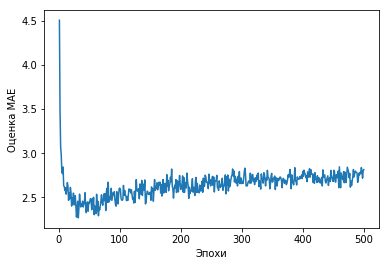

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Эпохи')
plt.ylabel('Оценка MAE')
plt.show()

Из-за проблем с масштабированием, а также ввиду относительно высокой дисперсии может быть немного затруднительно увидеть общую тенденцию. Давайте сделаем следующее:
* опустим первые 10 замеров, которые имеют другой масштаб, отличный от масштаба остальной кривой;
* заменим каждую оценку экспоненциальным скользящим средним по предыдущим оценкам, чтобы получить более гладкую кривую.

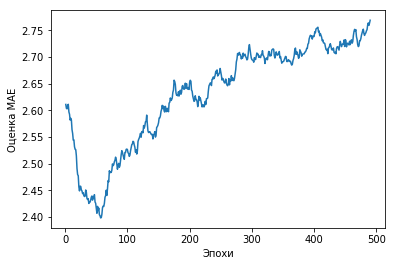

In [15]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Эпохи')
plt.ylabel('Оценка MAE')
plt.show()

Согласно этому графику, наилучшая оценка MAE достигается после 80 эпох. После
этого момента начинается переобучение.
По окончании настройки других параметров модели (кроме количества эпох можно
также скорректировать количество промежуточных слоев) можно обучить окончательную версию модели на всех обучающих данных, а затем оценить ее качество
на контрольных данных.

In [16]:
# Получить новую скомпилированную модель.
model = build_model()
# Обучить ее на всем объеме обучающих данных.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102==============================] - 0s 354us/sample - loss: 17.7073 - mean_absolute_error: 2.6827


Вот окончательный результат:

In [17]:
test_mae_score

2.6827226

Средняя ошибка все еще составляет около 2700 долларов.

## Задание

Необходимо путем настройки сети получить меньшую среднюю ошибку. 
Попытайтесь:
* добавить прореживание;
* опробовать разные архитектуры: добавлять и удалять слои;
* добавить L1- и (или) L2-регуляризацию;
* опробовать разные гиперпараметры (например, число нейронов на слой или шаг обучения оптимизатора), чтобы найти оптимальные настройки;
* дополнительно можно выполнить цикл конструирования признаков: добавить новые признаки или удалить имеющиеся, которые не кажутся информативными.


## Выводы

Вот какие выводы вы должны сделать из этого примера:
* Регрессия выполняется с применением иных функций потерь, нежели класси-
фикация. Для регрессии часто используется функция потерь, вычисляющая
среднеквадратичную ошибку (Mean Squared Error, MSE).
* Аналогично, для регрессии используются иные метрики оценки, нежели при
классификации; понятие точности неприменимо для регрессии, поэтому для
оценки качества часто применяется средняя абсолютная ошибка (Mean Absolute
Error, MAE).
* Когда признаки образцов на входе имеют значения из разных диапазонов, их
необходимо предварительно масштабировать.
* При небольшом объеме входных данных надежно оценить качество модели поможет метод перекрестной проверки по K блокам.
* При небольшом объеме обучающих данных предпочтительнее использовать маленькие сети с небольшим количеством промежуточных слоев (обычно с одним или двумя), чтобы избежать серьезного переобучения.
